In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns

#### Numpy & Python Version 확인

In [2]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.4
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


#### 모델 저장

In [4]:
def saveModel():
    torch.save(model.state_dict(), 'ARL1_L2_095.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [5]:
# 하이퍼파라미터 설정
length = 12             # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 2000         # 생성할 학습 데이터 시퀀스의 수 
validrun = 1000         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0.95로 생성)
phi1 = np.array([0.95])

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [6]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)
        
        for t in range(1, length):
            x[t] = ar1 * x[t - 1] + e[t]                        # 관리상태 시계열 데이터 생성
                               
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, phi in enumerate(phi1):
        y[i]= ar(phi, de1, ga, length, run)

    return y.reshape(run * len(phi1), length)                   # 생성된 데이터를 적절한 형태로 재배열


In [7]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                 # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [8]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [9]:
len(trainloader)

2000

In [10]:
len(validloader)

1000

In [11]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Encoder 클래스 정의
class Encoder(nn.Module):
    def __init__(self, seq_length, latent_dim, input_dim):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=latent_dim, num_layers=1, batch_first=True)
        self.seq_length = seq_length

    def forward(self, x):
        x, _ = self.lstm1(x)
        z, _ = self.lstm2(x)
        z_rep = z.unsqueeze(1).repeat(1, self.seq_length, 1)  # (batch_size, seq_length, latent_dim)
        return z, z_rep

# Decoder 클래스 정의
class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=latent_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.time_distributed = nn.Linear(128, input_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.time_distributed(x)
        return x

# 전체 LSTM 오토인코더 모델 정의
class LstmAE(nn.Module):
    def __init__(self, seq_length, input_dim, latent_dim):
        super(LstmAE, self).__init__()
        self.encoder = Encoder(seq_length, latent_dim, input_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def forward(self, x):
        z, z_rep = self.encoder(x)
        decoded = self.decoder(z_rep)
        return decoded

# 모델 인스턴스 생성 및 설정
seq_length = 12  # 시퀀스 길이
input_dim = 12   # 입력 차원
latent_dim = 2   # 잠재 차원

# 모델 인스턴스 생성 및 설정
model = LstmAE(seq_length=seq_length, input_dim=input_dim, latent_dim=latent_dim)
model = model.to(device)

In [13]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data                                                           # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs = 400)  # Set the appropriate number of epochs

/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 4.6701, Validation Loss: 4.5053
Validation loss decreased (inf --> 4.505284).  Saving model ...
Epoch 2, Train Loss: 4.6691, Validation Loss: 4.5040
Validation loss decreased (4.505284 --> 4.504003).  Saving model ...
Epoch 3, Train Loss: 4.6673, Validation Loss: 4.5020
Validation loss decreased (4.504003 --> 4.502016).  Saving model ...
Epoch 4, Train Loss: 4.6649, Validation Loss: 4.4993
Validation loss decreased (4.502016 --> 4.499266).  Saving model ...
Epoch 5, Train Loss: 4.6615, Validation Loss: 4.4956
Validation loss decreased (4.499266 --> 4.495637).  Saving model ...
Epoch 6, Train Loss: 4.6572, Validation Loss: 4.4910
Validation loss decreased (4.495637 --> 4.490973).  Saving model ...
Epoch 7, Train Loss: 4.6516, Validation Loss: 4.4848
Validation loss decreased (4.490973 --> 4.484754).  Saving model ...
Epoch 8, Train Loss: 4.6441, Validation Loss: 4.4764
Validation loss decreased (4.484754 --> 4.476439).  Saving model ...
Epoch 9, Train Loss: 4.6338, 

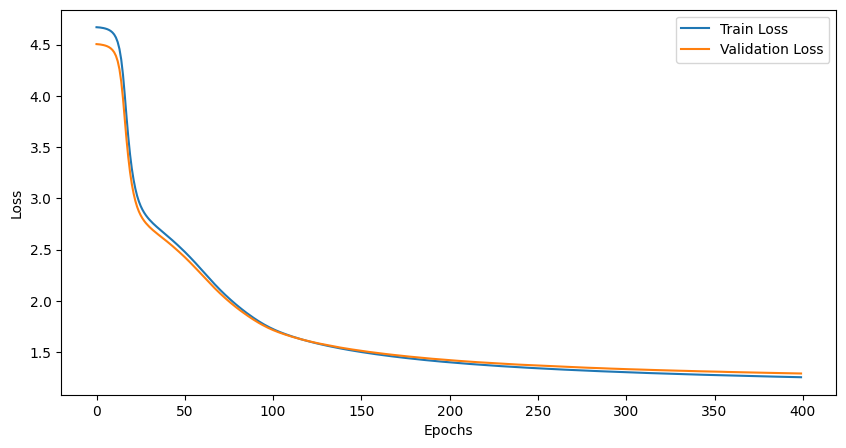

In [14]:
# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 모델 불러오기

In [13]:
model.load_state_dict(torch.load('ARL1_L2_095.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### 학습 데이터로부터  잠재 벡터 추출

In [15]:
latent_vectors = []
model.eval()
with torch.no_grad():
    for data in trainloader:
        inputs = data.to(device)
        latent_vec, _ = model.encoder(inputs)
        latent_vectors.append(latent_vec.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
latent_vectors

array([[ 0.6587235 ,  0.30086714],
       [-0.58465135, -0.54243535],
       [-0.00161163, -0.15113878],
       ...,
       [ 0.12690581, -0.07669798],
       [-0.15584436, -0.2023245 ],
       [ 0.7028131 ,  0.34468478]], dtype=float32)

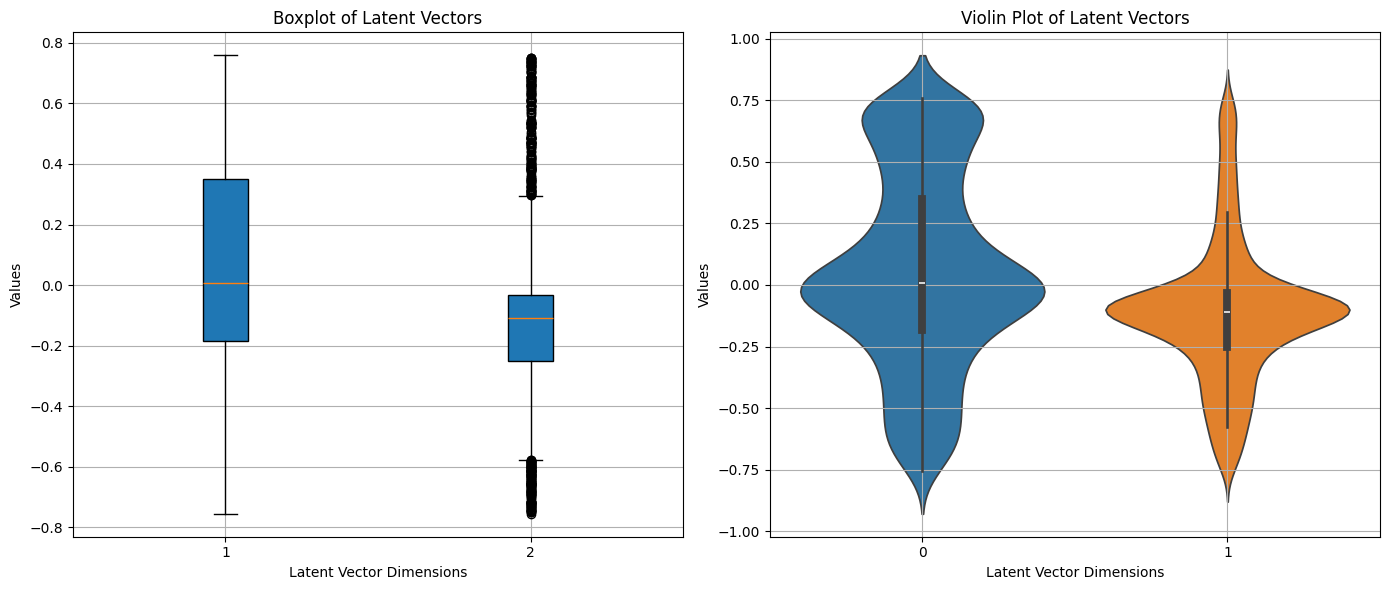

In [16]:
import seaborn as sns

# 박스플롯 및 바이올린 플롯 그리기
plt.figure(figsize=(14, 6))

# 박스플롯
plt.subplot(1, 2, 1)
plt.boxplot(latent_vectors, vert=True, patch_artist=True)
plt.xlabel('Latent Vector Dimensions')
plt.ylabel('Values')
plt.title('Boxplot of Latent Vectors')
plt.grid(True)

# 바이올린 플롯
plt.subplot(1, 2, 2)
sns.violinplot(data=latent_vectors, orient='v')
plt.xlabel('Latent Vector Dimensions')
plt.ylabel('Values')
plt.title('Violin Plot of Latent Vectors')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
def mahalanobis_distance(latent_vectors):
    # 평균 벡터 계산
    mean_vector = np.mean(latent_vectors, axis=0)
    
    # v_i 벡터 계산 (px1벡터)
    v = latent_vectors[1:] - latent_vectors[:-1]
    
    # 공분산 행렬 계산
    vvT = np.dot(v.T, v)
    cov_matrix = (1 / 2) * (vvT / (latent_vectors.shape[0] - 1))
    
    # 공분산 행렬의 역행렬 계산
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Mahalanobis 거리 계산 함수
    def calculate_distance(vector):
        diff = vector - mean_vector
        dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
        return dist
    
    # 각 벡터에 대해 Mahalanobis 거리 계산
    distances = np.apply_along_axis(calculate_distance, 1, latent_vectors)
    
    return distances

# latent_vectors 배열에 대해 Mahalanobis 거리 계산
distances = mahalanobis_distance(latent_vectors)
distances

array([1.5306882 , 1.6181402 , 0.1438426 , ..., 0.21069157, 0.7687646 ,
       1.6563193 ], dtype=float32)

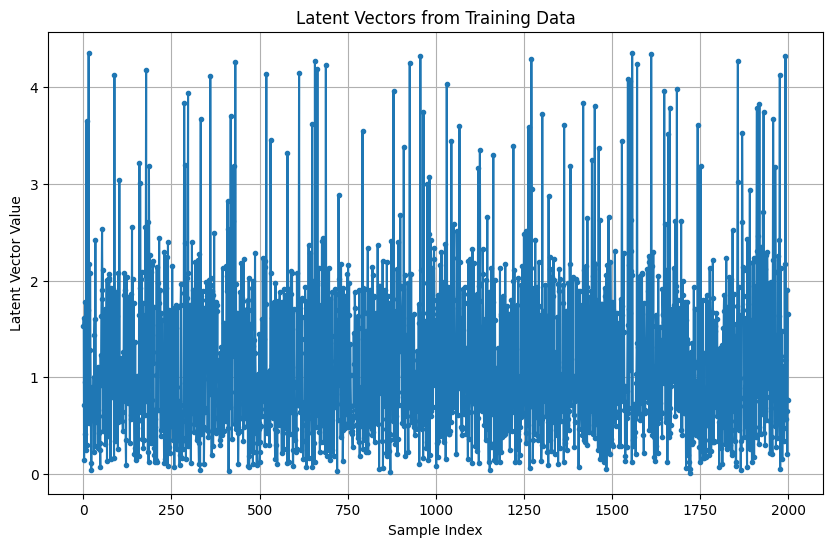

In [18]:
plt.figure(figsize=(10,6))
plt.plot(distances, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### 다변량 정규성 검정

In [19]:
import pandas as pd
import pingouin as pg

# latent_vectors를 DataFrame으로 변환 (pingouin 사용을 위해)
df = pd.DataFrame(latent_vectors)

# Mardia's Test 수행
mardia_test = pg.multivariate_normality(df, alpha = 0.05)

# mardia_test는 튜플로 반환됩니다.
hz_stat, p_value, normal = mardia_test

# 결과 출력 및 해석
print("Mardia's Test 결과:")
print(f"Test Statistic (HZ): {hz_stat}")
print(f"p-value: {p_value}")

if normal:
    print("데이터는 다변량 정규성을 따릅니다.")
else:
    print("데이터는 다변량 정규성을 따르지 않습니다.")


Mardia's Test 결과:
Test Statistic (HZ): 133.71553519774199
p-value: 4.161659528317246e-99
데이터는 다변량 정규성을 따르지 않습니다.


#### ARL0 구하기

In [20]:
np.random.seed(1)

l = 12

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, delta, gamma, length):

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(0,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(0,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [21]:
# 관리 상태에서 공분산 행렬과 평균 벡터 계산
def calculate_cov_mean(ar, run, length):
    l = 12
    delta = 0
    gamma = 1
    for i in tqdm(range(run)):
        y = argen(ar=ar, delta=delta, gamma=gamma, length=length)
        x = np.zeros(shape=(length - l, l))
        for j in range(length - l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)
        
        latent_vectors = []
        model.eval()
        with torch.no_grad():
            for j in range(0, len(x)):
                input = x[[j]]
                latent_vec, _ = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]
                latent_vectors.append(latent_vec_value)
        latent_vectors = np.array(latent_vectors)

    mean_vector = np.mean(latent_vectors, axis=0)
    v = latent_vectors[1:] - latent_vectors[:-1]
    vvT = np.dot(v.T, v)
    cov_matrix = (1 / 2) * (vvT / (latent_vectors.shape[0] - 1))
    inv_cov_matrix = np.linalg.inv(cov_matrix)
        
    return latent_vectors, mean_vector, cov_matrix, inv_cov_matrix

In [24]:
# def arl(ar, delta, gamma, run, length, mean_vector, inv_cov_matrix, cl):
#     rl = []
    
#     for i in tqdm(range(run)):
#         # 테스트 데이터 생성
#         y = argen(ar=ar, delta=delta, gamma=gamma, length=length)
#         x = np.zeros(shape=(length - l, l))
#         for j in range(length - l):
#             x[j] = y[j: j + l]
#         x = torch.FloatTensor(x).to(device)
        
#         # Latent vectors 추출
#         latent_vectors = []
#         model.eval()
#         with torch.no_grad():
#             for j in range(0, len(x)):
#                 input = x[[j]]
#                 latent_vec, _ = model.encoder(input)
#                 latent_vec_value = latent_vec.cpu().numpy()[0]
#                 latent_vectors.append(latent_vec_value)
#         latent_vectors = np.array(latent_vectors)

#         # ARL 계산
#         a = len(x)  # 기본적으로 length 값으로 초기화
        
#         with torch.no_grad():
#             # Mahalanobis 거리 계산 및 ARL 계산
#             for j in range(0, len(x)):
#                 latent_vec_value = latent_vectors[j]
                
#                 # Mahalanobis 거리 계산
#                 diff = latent_vec_value - mean_vector
#                 mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
                
#                 if mahalanobis_dist > cl:
#                     a = j + 1
#                     break
                  
#             rl.append(a)
        
#     arl = np.mean(rl)
        
#     return arl

In [22]:
def arl_moving_window(ar, delta, gamma, run, mean_vector, inv_cov_matrix, cl):
    rl = []
    l = 12
    for i in tqdm(range(run)):
        # 초기 데이터 생성
        y = argen(ar=ar, delta=delta, gamma=gamma, length=12)
        
        # 이동 윈도우 방식으로 ARL 계산
        a = 0
        model.eval()
        
        j = 1
        with torch.no_grad():
            while True:
                # 새 데이터 포인트 생성 및 윈도우에 추가
                new_point = argen(ar=ar, delta=delta, gamma=gamma, length=1)
                y = np.append(y[1:], new_point)
                
                # 현재 윈도우의 데이터
                x = torch.FloatTensor([y]).to(device)
                
                # Latent vector 추출
                latent_vec, _ = model.encoder(x)
                latent_vec_value = latent_vec.cpu().numpy()[0]
                
                # Mahalanobis 거리 계산
                diff = latent_vec_value - mean_vector
                mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
                
                # 탐지 여부 확인
                if mahalanobis_dist > cl:
                    a = j + 1
                    break

                j += 1
                
            rl.append(a)
        
        arl = np.mean(rl)
        
    return arl, rl

In [49]:
def arl(ar, delta, gamma, run, mean_vector, inv_cov_matrix, cl):
    rl = []
    l = 12
    for i in tqdm(range(run)):
        # 초기 데이터 생성
        y = argen(ar=ar, delta=delta, gamma=gamma, length=12)
        
        # 이동 윈도우 방식으로 ARL 계산
        a = 0
        model.eval()
        
        j = 1
        with torch.no_grad():
            while True:
                # 새 데이터 포인트 생성 및 윈도우에 추가
                new_point = argen(ar=ar, delta=delta, gamma=gamma, length=1)
                y = np.append(y[1:], new_point)
                
                # 현재 윈도우의 데이터
                x = torch.FloatTensor([y]).to(device)
                
                # Latent vector 추출
                latent_vec, _ = model.encoder(x)
                latent_vec_value = latent_vec.cpu().numpy()[0]
                
                # Mahalanobis 거리 계산
                diff = latent_vec_value - mean_vector
                mahalanobis_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
                
                # 탐지 여부 확인
                if mahalanobis_dist > cl:
                    a = j + 1
                    break

                j += 1
                
            rl.append(a)
        
        arl = np.mean(rl)
        
    return arl

#### ARL1 구하기

In [50]:
def arl1(ar, run, mean_vector, inv_cov_matrix, cl):
    a5 = arl(ar, 0.5, 1, run, mean_vector, inv_cov_matrix, cl)
    a1 = arl(ar, 1, 1, run, mean_vector, inv_cov_matrix, cl)
    a2 = arl(ar, 2, 1, run, mean_vector, inv_cov_matrix, cl)
    a3 = arl(ar, 3, 1, run, mean_vector, inv_cov_matrix, cl)
    b5 = arl(ar, 0.5, 1.5, run, mean_vector, inv_cov_matrix, cl)
    b1 = arl(ar, 1, 1.5, run, mean_vector, inv_cov_matrix, cl)
    b2 = arl(ar, 2, 1.5, run, mean_vector, inv_cov_matrix, cl)
    b3 = arl(ar, 3, 1, run, mean_vector, inv_cov_matrix, cl)
    c1 = arl(ar, 0, 1.5, run, mean_vector, inv_cov_matrix, cl)
    c2 = arl(ar, 0, 2, run, mean_vector, inv_cov_matrix, cl)
    c3 = arl(ar, 0, 3, run, mean_vector, inv_cov_matrix, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### phi = 0.95일 때

##### ARL0 (threshold 임의추정)

In [26]:
# 관리 상태에서 잠재벡터, 평균벡터, 공분산 계산
latent_vectors095, mean_vector095, cov_matrix095, inv_cov_matrix095 = calculate_cov_mean(ar = 0.95, run = 10000, length = 1000)

100%|██████████| 10000/10000 [16:50<00:00,  9.89it/s] 


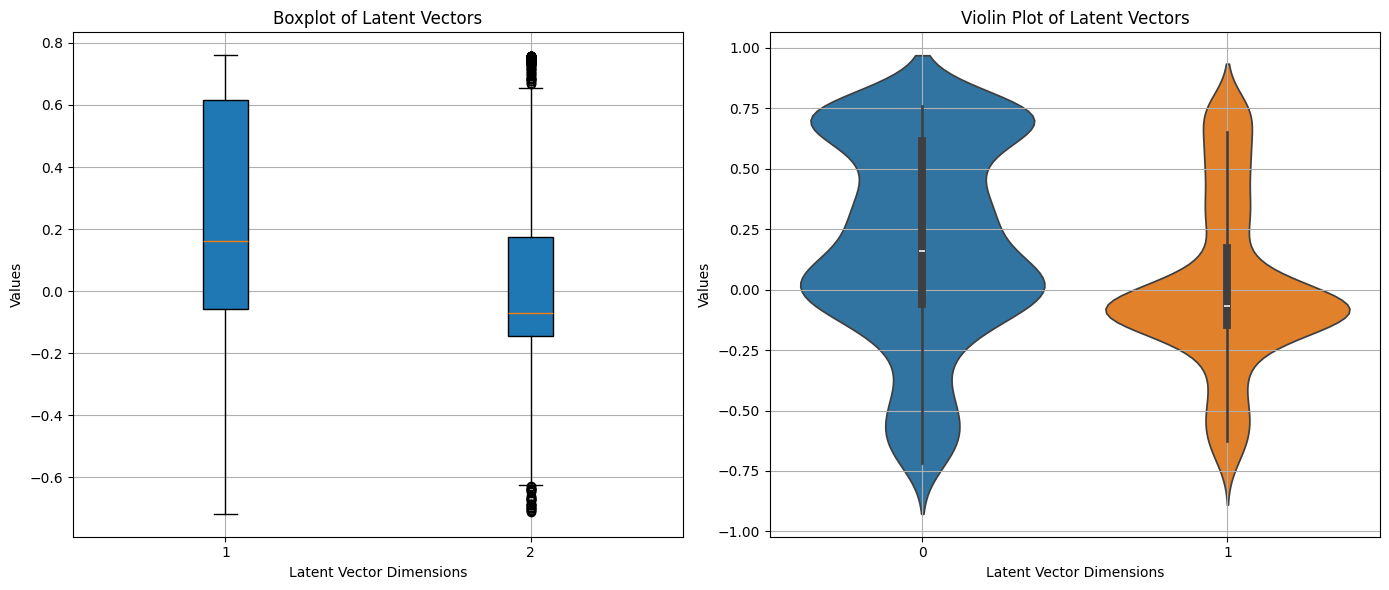

In [27]:
# 잠재벡터 분포 확인
import seaborn as sns

# 박스플롯 및 바이올린 플롯 그리기
plt.figure(figsize=(14, 6))

# 박스플롯
plt.subplot(1, 2, 1)
plt.boxplot(latent_vectors095, vert=True, patch_artist=True)
plt.xlabel('Latent Vector Dimensions')
plt.ylabel('Values')
plt.title('Boxplot of Latent Vectors')
plt.grid(True)

# 바이올린 플롯
plt.subplot(1, 2, 2)
sns.violinplot(data=latent_vectors095, orient='v')
plt.xlabel('Latent Vector Dimensions')
plt.ylabel('Values')
plt.title('Violin Plot of Latent Vectors')
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
mean_vector095

array([0.19038488, 0.00426749], dtype=float32)

In [29]:
cov_matrix095

array([[0.00182451, 0.00075782],
       [0.00075782, 0.0011861 ]], dtype=float32)

In [30]:
inv_cov_matrix095

array([[ 746.0861, -476.6856],
       [-476.6856, 1147.6605]], dtype=float32)

In [33]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10)
arl

100%|██████████| 10000/10000 [03:12<00:00, 51.94it/s]


168.2327

In [35]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 11)
arl

100%|██████████| 10000/10000 [06:58<00:00, 23.87it/s]


376.6668

In [36]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.9)
arl

100%|██████████| 10000/10000 [06:33<00:00, 25.40it/s]


350.322

In [37]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.95)
arl

100%|██████████| 10000/10000 [06:51<00:00, 24.28it/s]


366.4224

In [38]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.96)
arl

100%|██████████| 10000/10000 [06:46<00:00, 24.59it/s]


361.9671

In [39]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.98)
arl

100%|██████████| 10000/10000 [06:59<00:00, 23.86it/s]


376.3406

In [40]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.97)
arl

100%|██████████| 10000/10000 [06:48<00:00, 24.49it/s]


364.99

In [41]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.975)
arl

100%|██████████| 10000/10000 [06:50<00:00, 24.36it/s]


370.1602

In [42]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.976)
arl

100%|██████████| 10000/10000 [06:57<00:00, 23.92it/s]


373.6915

In [43]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.9755)
arl

100%|██████████| 10000/10000 [06:56<00:00, 24.00it/s]


376.9509

In [44]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.975)
arl

100%|██████████| 10000/10000 [06:51<00:00, 24.30it/s]


377.2698

In [45]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.9745)
arl

100%|██████████| 10000/10000 [06:56<00:00, 24.01it/s]


374.2747

In [46]:
arl, rl = arl_moving_window(ar = 0.95, delta = 0, gamma = 1, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.974)
arl

100%|██████████| 10000/10000 [06:33<00:00, 25.42it/s]


370.8167

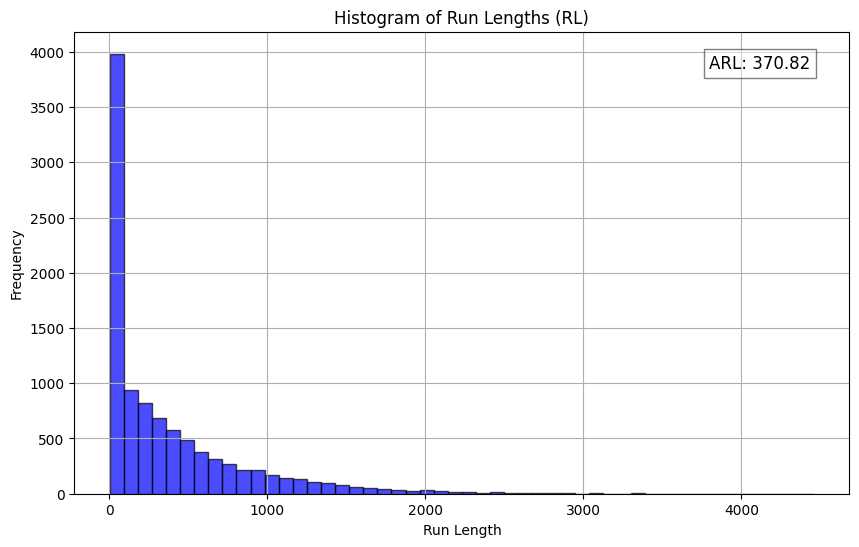

In [47]:
# rl에 대한 히스토그램 생성
plt.figure(figsize=(10, 6))
plt.hist(rl, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Run Lengths (RL)')
plt.xlabel('Run Length')
plt.ylabel('Frequency')
plt.grid(True)

# ARL 값을 히스토그램 위에 표시
plt.text(0.95, 0.95, f'ARL: {arl:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

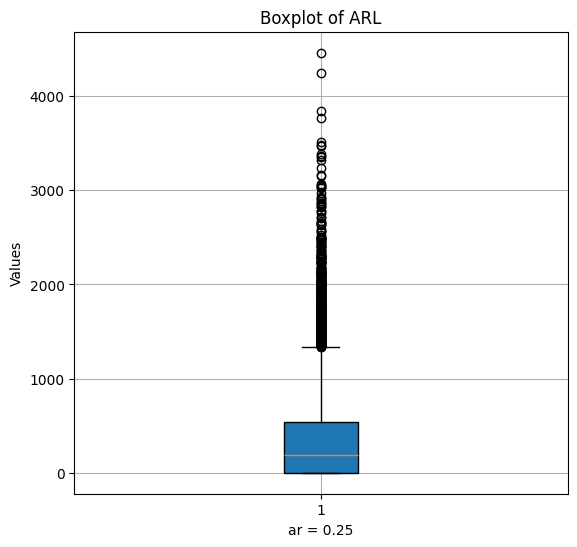

In [48]:
# 잠재벡터 분포 확인
import seaborn as sns

plt.figure(figsize=(14, 6))
# 박스플롯
plt.subplot(1, 2, 1)
plt.boxplot(rl, vert=True, patch_artist=True)
plt.xlabel('ar = 0.25')
plt.ylabel('Values')
plt.title('Boxplot of ARL')
plt.grid(True)

##### ARL1

In [51]:
arl1(ar = 0.95, run = 10000, mean_vector = mean_vector095, inv_cov_matrix = inv_cov_matrix095, cl = 10.974)

100%|██████████| 10000/10000 [00:08<00:00, 1124.21it/s]

0.5: 8.62, 1:2.7788,2:2.0097,3:2.0
0.5:7.6403,1:3.2885,2:2.1015,3:2.0
1.5:66.832,2:23.1683,3:7.6502
